In [16]:
import re
import random
import pandas as pd
import hashlib

In [17]:
with open("certcards2.txt", mode="r", encoding="utf8") as f:
    all_cards = f.read()

card_split_pattern = r"\n\n\n\d+\n"
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r"(.+?)\n([\s\S]+)", re.DOTALL)
cards = [
    (match.group(1), match.group(2))
    for cstring in all_cards
    if (match := re.search(card_pattern, cstring))
]

# removing the cards that have no content and trimming
cards = [
    (subject, stripped_content)
    for subject, content in cards
    if len(stripped_content := content.strip()) > 5
]


def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode("utf-8")).hexdigest()


def remake_card_document(
    existing_cards: pd.DataFrame, filename: str = "certcards2.txt"
):
    with open(filename, mode="w", encoding="utf8") as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write("\n" * 6)
            f.write(str(i) + "\n")
            f.write(row["head"] + "\n")
            f.write(row["body"])
            i += 1
    print(f"Cards found: {existing_cards.shape[0]}")
    print(f"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=["head", "body"])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards["hash"] = existing_cards["body"].apply(hash_string_md5)

card_ages = pd.read_json("card_ages.json")
card_ages = card_ages.drop_duplicates(subset=["hash"], keep="first")

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[["hash", "age"]],
    left_on="hash",
    right_on="hash",
    how="left",
)


cards_to_age["head"] = cards_to_age["head"].str.strip()

# remove headers I don't want anymore
undesired_headers = ["CCH Axcess"]
cards_to_age = cards_to_age.loc[~cards_to_age["head"].isin(undesired_headers), :].copy()

cards_to_age["age"] = cards_to_age["age"].fillna(0)

age_factor = 1.01
cards_to_age["age"] = cards_to_age["age"] * age_factor

cards_to_age["age"] = cards_to_age["age"] + [
    random.expovariate(0.5) for _ in cards_to_age.index
]



mean = cards_to_age["age"].mean()
threshold = .005+(mean/2000)
shuffle_role = random.random()
print(f"{shuffle_role=:.6f}; {threshold=:.6f}")
if shuffle_role < threshold:
    cards_to_age["age"] = cards_to_age["age"] * [
        random.expovariate(1.3) for _ in cards_to_age.index
    ]

# Adding priority age growth to cards for upcoming certifications 
priority_headers = [
    "Django", 
    "CCH Tax Forms Project",
    "Microsoft Purview"
    ]
priority_cards_mask = cards_to_age["head"].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, "age"] = (
    cards_to_age.loc[priority_cards_mask, "age"] * 1.0718
)

cards_to_age = cards_to_age.drop_duplicates(subset=["hash"], keep="first")

cards_to_age["subject_mean_age"] = cards_to_age.groupby("head")["age"].transform("mean")
cards_to_age["subject_highest_age"] = cards_to_age.groupby("head")["age"].transform(
    "max"
)
cards_to_age["subject_age_sum"] = cards_to_age.groupby("head")["age"].transform("sum")
cards_to_age["head_random_roll"] = cards_to_age.groupby("head")["head"].transform(
    lambda x: random.random()
)
cards_to_age["head_count"] = cards_to_age.groupby("head")["head"].transform("count")


cards_to_age.sort_values("hash")[["age", "head", "hash"]].to_json(
    "card_ages.json", indent=2
)

existing_cards = cards_to_age

shuffle_role=0.132037; threshold=0.018719


In [18]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Ansible,277.172096,6.929302,15.582563,40
ODBC,145.279244,9.079953,48.217001,16
Network Terms,180.884616,12.058974,46.294731,15
"Everything is Tuberculosis, Green",309.839031,13.471262,50.865153,23
Exchange Online and Defender,1028.557924,15.584211,179.708888,66
"The Mines of the Behemoth, Shea",1118.105439,22.818478,149.162722,49
eDiscovery,1255.318071,23.685247,150.896774,53
WinHex,495.485476,24.774274,146.975768,20
Ubuntu,658.390354,25.322706,141.619129,26
Python,1293.547107,25.870942,163.708926,50


# Histogram

sum of ages: ~22047.00


<Axes: >

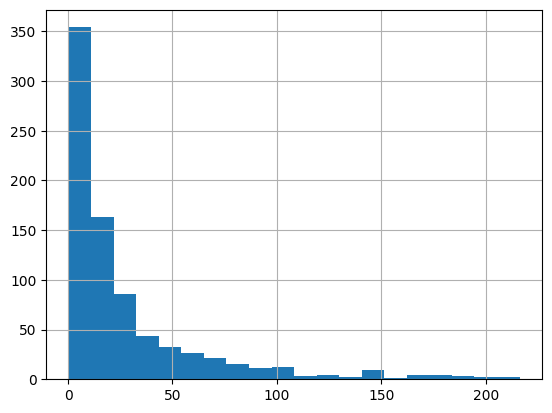

In [19]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~22047.00


<Axes: >

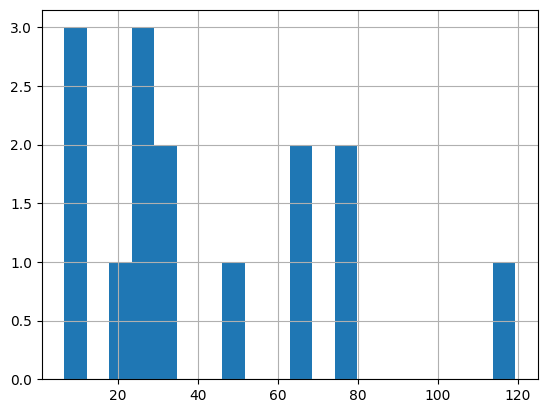

In [20]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='CCH Tax Forms Project']['age'].hist(bins=20)

# Completely Random Shuffle

In [21]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [22]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [23]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // m

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [ ]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

Cards found: 798
Total card age: 22047.00


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
26,"The Simulacra, Dick",quondam (KWON-dam)\nadjective\nFormer or previ...,e5960a57b5b1b681f82bb109dcf70b69,-127.938482,-51.120173,127.938482,613.442080,0.743402,12,0,0
78,"The Simulacra, Dick",papoola (pah-POO-luh)\nnoun\nA term from Kipli...,1e9eea2ecb6657695cbe015c39462339,-70.557363,-51.120173,127.938482,613.442080,0.743402,12,3,0
162,"The Simulacra, Dick",proctological (prok-tuh-LOJ-ih-kul)\nadjective...,15f313397556358982050fba7294b788,-39.723104,-51.120173,127.938482,613.442080,0.743402,12,6,0
355,"The Simulacra, Dick",garrulous (GAR-uh-lus)\nadjective\nExcessively...,86885b90d4ff2d1ae25480b1ff943c72,-13.019381,-51.120173,127.938482,613.442080,0.743402,12,9,0
33,CCH Tax Forms Project,"The <Identifier Hierarchy=""…""> attribute in XM...",e9d59f6d65587472a0ac4700d5b8e3a4,-119.396897,-42.796531,119.396897,641.947967,0.459019,15,0,0
93,CCH Tax Forms Project,xml.etree.ElementTree.iterparse() is a Python ...,e9b912aa7acdb907640e8ab62d52f15d,-68.237618,-42.796531,119.396897,641.947967,0.459019,15,3,0
208,CCH Tax Forms Project,Streaming both the .zip container (with zipfil...,6020c37331782296b015ebec7383ecd4,-34.516078,-42.796531,119.396897,641.947967,0.459019,15,6,0
231,CCH Tax Forms Project,"The elem.get(""AttributeName"") method in Python...",4a9a07a00a50f0e78605485d6fbd3059,-26.122047,-42.796531,119.396897,641.947967,0.459019,15,9,0
411,CCH Tax Forms Project,"With Python’s zipfile, you can stream files di...",55fac6e8a4003f479483223ef766d546,-11.355649,-42.796531,119.396897,641.947967,0.459019,15,12,0
0,Active Directory and Azure Files,NetBIOS Domain Name\nThe short (pre–DNS) name ...,929a063a42e9db577cc3e5c542824a25,-212.393032,-42.672993,212.393032,1237.516794,0.478933,29,0,0


## Age Max

In [25]:
# n = random.choice([2, 3, 3, 4, 4, 5])

# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [ ]:
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()

choices = ['floor', 'mod']
option = random.choice(choices)
if option == 'floor':
    n=existing_cards.shape[0]//100
    existing_cards['n_fold'] = existing_cards['count'] // n
    print("floor dividing for n-fold")
elif option == 'mod':
    n=3
    existing_cards['n_fold'] = existing_cards['count'] % n
    print("modulo for n-fold")
else: raise NotImplementedError


if existing_cards['age'].sum() > 0:
    # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
    existing_cards['subject_highest_age'] *= -1
existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)


## Random

In [27]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [28]:
existing_cards.head(10)['age'].sum()

np.float64(-723.2596512120155)

In [29]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
1,Microsoft Purview,"When viewed by users in your organization, an ...",9735b36099be5c4b66df7b3da4c7e94a,-216.225216,-32.458646,216.225216,1071.135329,0.956060,33,0,0
0,Active Directory and Azure Files,NetBIOS Domain Name\nThe short (pre–DNS) name ...,929a063a42e9db577cc3e5c542824a25,-212.393032,-42.672993,212.393032,1237.516794,0.478933,29,0,0
2,Docker,Compose Profiles\nEnable or disable optional s...,9b3012f07c186a9bcd20b86a12a77f0b,-203.911889,-33.158667,203.911889,994.760002,0.030621,30,0,0
3,Terraform Codebox,Shebang (#!/bin/bash)\nThe first line in many ...,1e5d7b5c48fc5c9694191b41f91bae92,-196.019095,-32.844495,196.019095,952.490365,0.616025,29,0,0
4,Node.js and Vite,tailwind.config.js\nTells Tailwind where to lo...,f960b0747c547be5e142294c0e557df2,-191.196759,-40.466194,191.196759,1213.985828,0.394104,30,0,0
7,Windows PATH Variable,Duplicate Entries\nWhen the same directory app...,302556647410ce4ab20793e675f1b674,-188.819534,-29.829129,188.819534,775.557358,0.638478,26,0,0
5,Azure Files Documentation,The Kerberos Key Distribution Center (KDC) is ...,2fe3be166485c1be2c565b9dc3725eeb,-188.446137,-39.860355,188.446137,1554.553835,0.329566,39,0,0
6,SSH + SCP,PermitRootLogin (sshd)\nControls whether root ...,e7f28bc55845b01b2c16b5bc3f48b9c9,-183.417097,-26.120855,183.417097,757.504794,0.779104,29,0,0
8,Exchange Online and Defender,You can integrate Defender for Office 365 with...,0f497c29704ee48dd3881866fc98d276,-179.708888,-15.584211,179.708888,1028.557924,0.695295,66,0,0
9,Azure Files Documentation,"In the OSI networking model, Microsoft SMB Pro...",a2af1bc565a17fa283e961a66d1487c0,-179.661847,-39.860355,188.446137,1554.553835,0.329566,39,1,1


In [30]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 27.628'